
 <div style=" border-radius: 10px ; padding: 10px; background-color: #1E3A5F; max-width:1000px; margin: auto;">
<h1 style="color:white;text-align:center;">Loan Approval Prediction: A Balanced Data Approach</h1>

<div style=" border-radius: 10px; padding: 10px; background-color: #4A4A4A; max-width: 600px; margin: auto;">
<h2 style="color:white;text-align:center;">Introduction</h2>
</div><br><br>
<p>The goal of this project is to build a predictive model that can determine the likelihood of a loan being approved based on a set of applicant characteristics. </p>

- Data Preprocessing: Steps taken to clean and transform raw data, including encoding categorical variables and scaling numeric features.  

- Exploratory Data Analysis (EDA): Visualizations and insights into how various features relate to loan approval likelihood.  

- Modeling: An end-to-end modeling pipeline that includes handling class imbalance, training with logistic regression, and evaluating the model.

- Performance Evaluation: Using metrics like AUC-ROC, confusion matrix, and classification report to assess the model's performance.

- Deployment: The model is deployed as an interactive web app, allowing real-time predictions based on user inputs. 

  
  This project highlights a complete workflow from data preparation to deployment, with an emphasis on balanced data for accurate loan approval predictions.


<div style=" border-radius: 10px; padding: 10px; background-color: #4A4A4A; max-width: 600px; margin: auto;">
<h2 style="color:white;text-align:center;">Import Libraries</h2> 

In [53]:
import numpy as np  # For linear algebra
import pandas as pd  # For data processing, CSV file I/O (e.g., pd.read_csv)
import seaborn as sns  # For data visualization
import matplotlib.pyplot as plt  # For data visualization
import os  # For interacting with the file system
import warnings  # For managing warnings
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # For data scaling and encoding
from sklearn.compose import ColumnTransformer  # For applying transformers to subsets of data
from sklearn.pipeline import Pipeline  # For creating a pipeline of transformations and classifiers
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.linear_model import LogisticRegression  # For logistic regression model
from imblearn.over_sampling import SMOTE  # For balancing classes in imbalanced datasets
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve  # For model evaluation metrics
from imblearn.pipeline import Pipeline as ImbPipeline
from IPython.display import display  # For displaying widgets
import joblib  # For saving and loading models

<div style=" border-radius: 10px; padding: 10px; background-color: #4A4A4A; max-width: 600px; margin: auto;">
<h2 style="color:white;text-align:center;">Exploratory Data Analysis (EDA)</h2></div><br><br>  
<p>This step helps us understand the dataset’s distribution and relationships between features.</p>

In [46]:
# Suppress specific FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Check the files in the Kaggle input directory 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Read dataset
df = pd.read_csv('/kaggle/input/loan-data/loan_data.csv')



/kaggle/input/loan-data/loan_data.csv


<div style="border-radius: 10px; padding: 10px; background-color: #D3D3D3; max-width: 600px;">
  <h3 style="color:black;text-align:center;">Summary information</h3>
</div>

In [47]:
# Create a summary DataFrame with data types and non-null counts for each column
info_df = pd.DataFrame({
    "Column": df.columns,  # Name of each column in the DataFrame
    "Data Type": df.dtypes,  # Data type of each column
    "Non-Null Count": df.notnull().sum(),  # Count of non-null (valid) entries for each column
    "Total Count": len(df)  # Total number of rows (entries) in the DataFrame
})

# Calculate the percentage of non-null values in each column
info_df['Non-Null Percentage'] = (info_df['Non-Null Count'] / info_df['Total Count'] * 100).round(2).astype(str) + '%'

# Apply styling to the table and display it
info_df_styled = info_df.style.set_properties(**{'text-align': 'left'}).set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#d9edf7'), ('color', '#31708f'), ('font-weight', 'bold')]}]
)

# Apply a background gradient to the numerical columns for better visualization
info_df_styled = info_df_styled.background_gradient(subset=['Non-Null Count', 'Total Count'], cmap="Oranges")

# Display the styled table
display(info_df_styled)

,Column,Data Type,Non-Null Count,Total Count,Non-Null Percentage
credit.policy,credit.policy,int64,9578,9578,100.0%
purpose,purpose,object,9578,9578,100.0%
int.rate,int.rate,float64,9578,9578,100.0%
installment,installment,float64,9578,9578,100.0%
log.annual.inc,log.annual.inc,float64,9578,9578,100.0%
dti,dti,float64,9578,9578,100.0%
fico,fico,int64,9578,9578,100.0%
days.with.cr.line,days.with.cr.line,float64,9578,9578,100.0%
revol.bal,revol.bal,int64,9578,9578,100.0%
revol.util,revol.util,float64,9578,9578,100.0%


<div style="border-radius: 10px; padding: 10px; background-color: #D3D3D3; max-width: 600px;">
  <h3 style="color:black;text-align:center;">Missing value</h3>
</div>

In [48]:
# Display the message about missing values 
print("\033[1;31mMissing values detected in the following columns:\033[0m")  # Prints a colored message indicating missing values
print(df.isnull().sum())  # Shows the count of missing (null) values for each column in the DataFrame


Missing values detected in the following columns:
credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64


<div style="border-radius: 10px; padding: 10px; background-color: #D3D3D3; max-width: 600px;">
  <h3 style="color:black;text-align:center;">Distribution of Variables</h3>
</div>

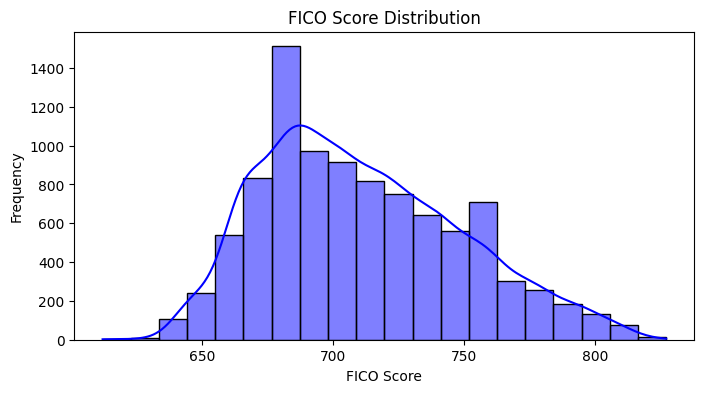

In [3]:
# FICO score distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['fico'], kde=True, color='blue', bins=20)
plt.title("FICO Score Distribution")
plt.xlabel("FICO Score")
plt.ylabel("Frequency")
plt.show()

<div style="border-radius: 10px; padding: 10px; background-color: #D3D3D3; max-width: 600px;">
  <h3 style="color:black;text-align:center;">Categorical Variables</h3>
</div>

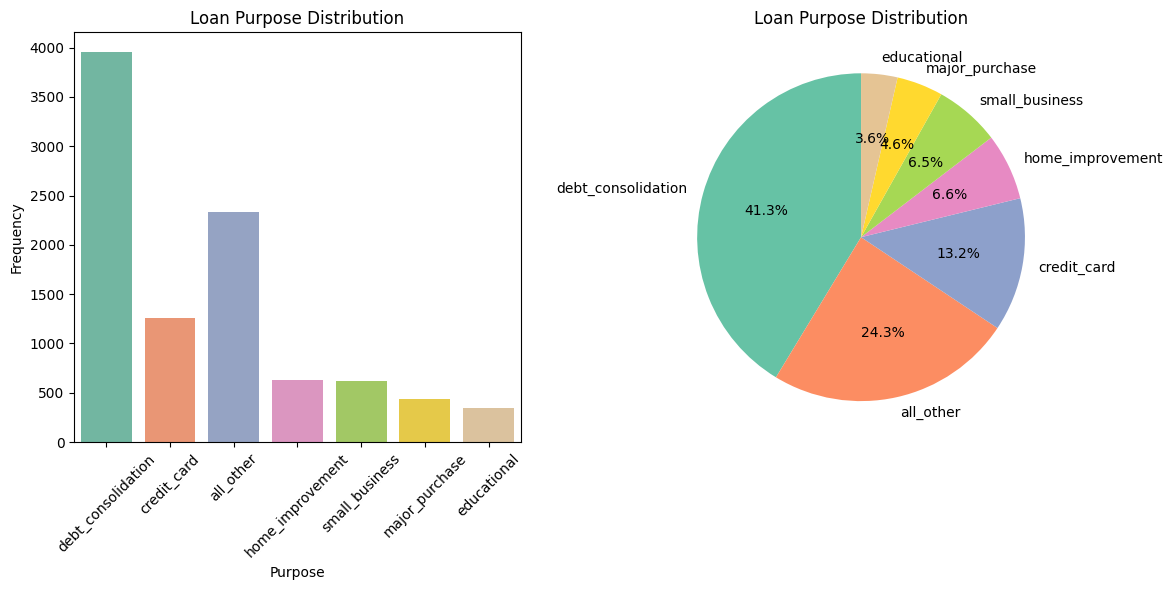

In [49]:
# Frequency of each loan purpose
loan_purpose_counts = df['purpose'].value_counts()

# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Count plot (on the first subplot)
sns.countplot(x='purpose', data=df, palette='Set2', ax=axes[0])
axes[0].set_title("Loan Purpose Distribution")
axes[0].set_xlabel("Purpose")
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis='x', rotation=45)

# Pie chart (on the second subplot)
axes[1].pie(loan_purpose_counts, labels=loan_purpose_counts.index, autopct='%1.1f%%', 
            colors=sns.color_palette('Set2', len(loan_purpose_counts)), startangle=90)
axes[1].set_title("Loan Purpose Distribution")

# Display the plots
plt.tight_layout() 
plt.show()

<div style="border-radius: 10px; padding: 10px; background-color: #D3D3D3; max-width: 600px;">
  <h3 style="color:black;text-align:center;">Relationships Between Variables</h3>
</div>

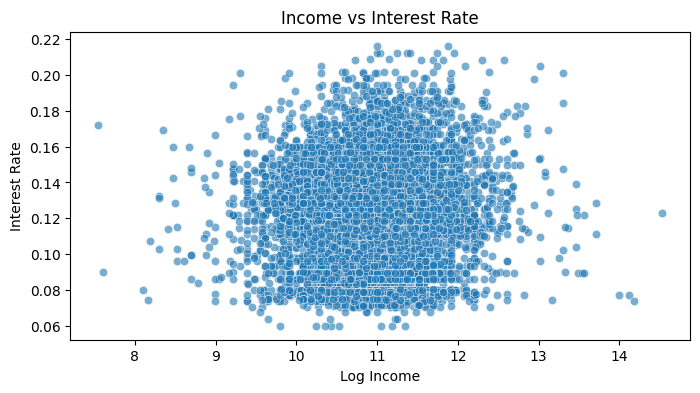

In [5]:
# Relationship between income and interest rate
plt.figure(figsize=(8, 4))
sns.scatterplot(x='log.annual.inc', y='int.rate', data=df, alpha=0.6)
plt.title("Income vs Interest Rate")
plt.xlabel("Log Income")
plt.ylabel("Interest Rate")
plt.show()

<div style=" border-radius: 10px; padding: 10px; background-color: #4A4A4A; max-width: 600px; margin: auto;">
<h2 style="color:white;text-align:center;">Feature Correlations & Loan Status Distribution</h2>  


<Figure size 1200x600 with 0 Axes>

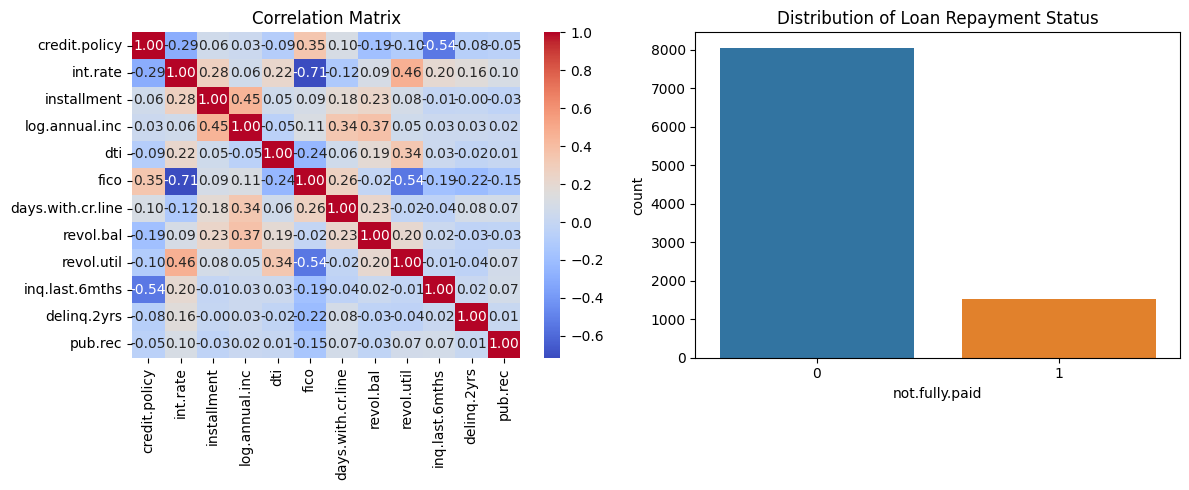

In [6]:
# Convert relevant columns to categorical 
df['not.fully.paid'] = df['not.fully.paid'].astype('category')

# Select only numeric columns for correlation matrix calculation
df_numeric = df.select_dtypes(include=[float, int])

# Create a 1x2 grid for the plots
plt.figure(figsize=(12, 6))

# Create subplots for the correlation matrix and target distribution
fig, axes = plt.subplots(1, 2, figsize=(12,5)) 

# Plot Correlation Matrix
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', ax=axes[0], fmt='.2f') 
axes[0].set_title('Correlation Matrix')

# Plot Distribution of Loan Repayment Status (Target Variable)
sns.countplot(x='not.fully.paid', data=df, ax=axes[1])
axes[1].set_title('Distribution of Loan Repayment Status')

# Show the plots
plt.tight_layout()  
plt.show()

<div style="border-radius: 10px; padding: 10px; background-color: #D3D3D3; max-width: 600px;">
  <h3 style="color:black;text-align:center;">Data Balance Analysis</h3>
</div>

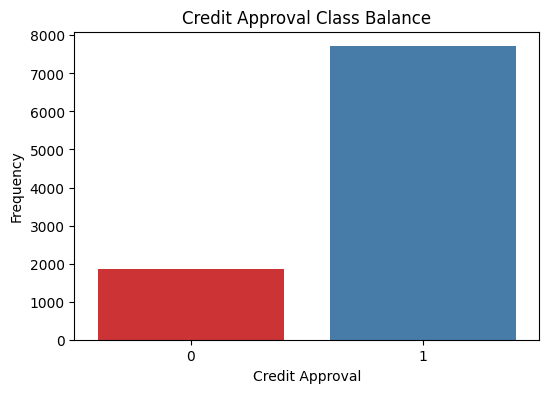

In [7]:
# Class balance of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='credit.policy', data=df, palette='Set1')
plt.title("Credit Approval Class Balance")
plt.xlabel("Credit Approval")
plt.ylabel("Frequency")
plt.show()

<div style=" border-radius: 10px; padding: 10px; background-color: #4A4A4A; max-width: 600px; margin: auto;">
<h2 style="color:white;text-align:center;">Model Training and Evaluation</h2>  


In [50]:
# OneHotEncoding for categorical columns and scaling for numeric columns
# Prepare data for training
data = df.copy()

# Separate features (X) and target (y)
X = data.drop('credit.policy', axis=1)  # Drop the target column
y = data['credit.policy']  # Target variable

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline (scaling numeric features and encoding categorical features)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 
                                   'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 
                                   'delinq.2yrs', 'pub.rec']),
        ('cat', OneHotEncoder(), ['purpose']) 
    ]
)

# Create an imbalanced-learn pipeline that includes SMOTE and Logistic Regression
imb_model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # First, preprocess the data (scale numeric, encode categorical)
    ('smote', SMOTE(random_state=42, sampling_strategy=0.5)),  # Apply SMOTE to balance the dataset
    ('classifier', LogisticRegression(max_iter=1000000))  # Logistic Regression classifier
])

# Train the model with the full pipeline
imb_model_pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = imb_model_pipeline.predict(X_test)
y_pred_proba = imb_model_pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Adjust the decision threshold to improve recall of the positive class
threshold = 0.3
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate the model using classification report
classification_rep = classification_report(y_test, y_pred_adjusted, output_dict=True)

# Convert the classification report to a DataFrame for display as a table with styles
classification_df = pd.DataFrame(classification_rep).transpose()
classification_df_styled = classification_df.style.set_properties(**{
    'text-align': 'center', 
    'font-size': '10pt' 
}).set_table_styles(
    [
        {'selector': 'th', 
         'props': [
             ('background-color', '#d9edf7'), 
             ('color', '#31708f'), 
             ('font-weight', 'bold'),
             ('font-size', '10pt') 
         ]
        },
        {'selector': 'td', 
         'props': [
             ('padding', '10px') 
         ]
        }
    ]
)





<div style="border-radius: 10px; padding: 10px; background-color: #D3D3D3; max-width: 600px;">
  <h3 style="color:black;text-align:center;">Confusion Matrix & ROC curve</h3>
</div>

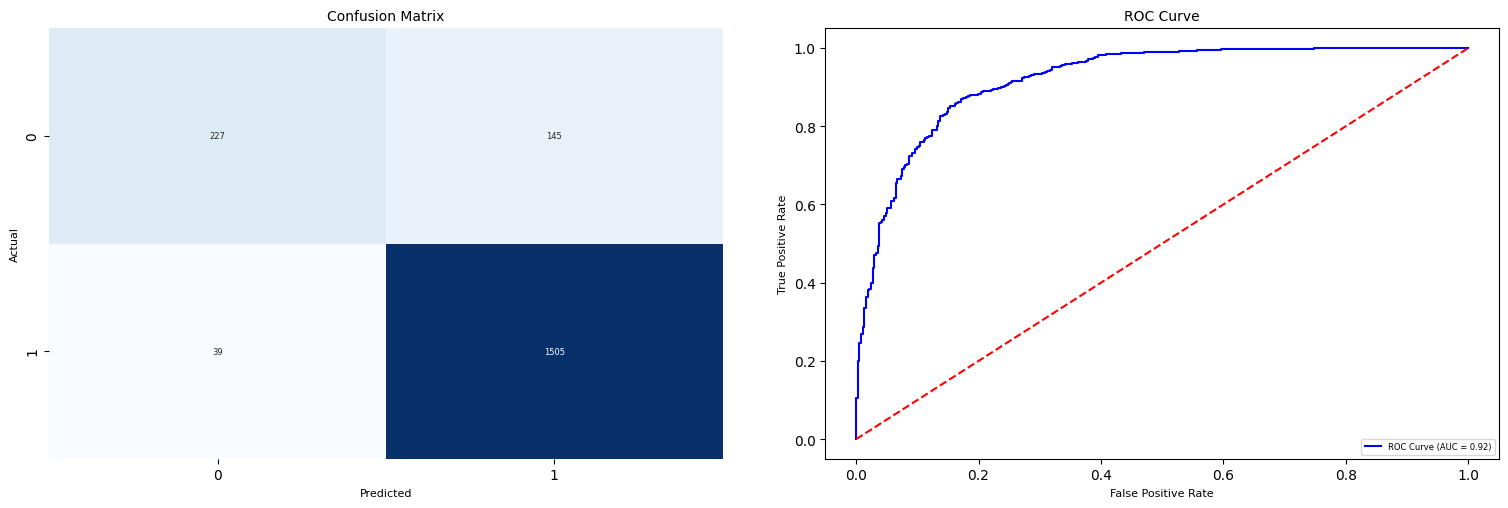

In [51]:
# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
# Create the first block: 2 aligned plots in one row
fig1, axes1 = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes1[0], annot_kws={"size": 6})
axes1[0].set_title("Confusion Matrix", fontsize=10)
axes1[0].set_xlabel("Predicted", fontsize=8)
axes1[0].set_ylabel("Actual", fontsize=8)

# ROC Curve
axes1[1].plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_roc:.2f})')
axes1[1].plot([0, 1], [0, 1], color='red', linestyle='--')
axes1[1].set_title("ROC Curve", fontsize=10)
axes1[1].set_xlabel("False Positive Rate", fontsize=8)
axes1[1].set_ylabel("True Positive Rate", fontsize=8)
axes1[1].legend(loc="lower right", fontsize=6)

# Adjust layout for the first row
plt.tight_layout(pad=4.0)  
plt.show()

<div style="border-radius: 10px; padding: 10px; background-color: #D3D3D3; max-width: 600px;">
  <h3 style="color:black;text-align:center;">Classification Table & AUC-ROC Score</h3>
</div>

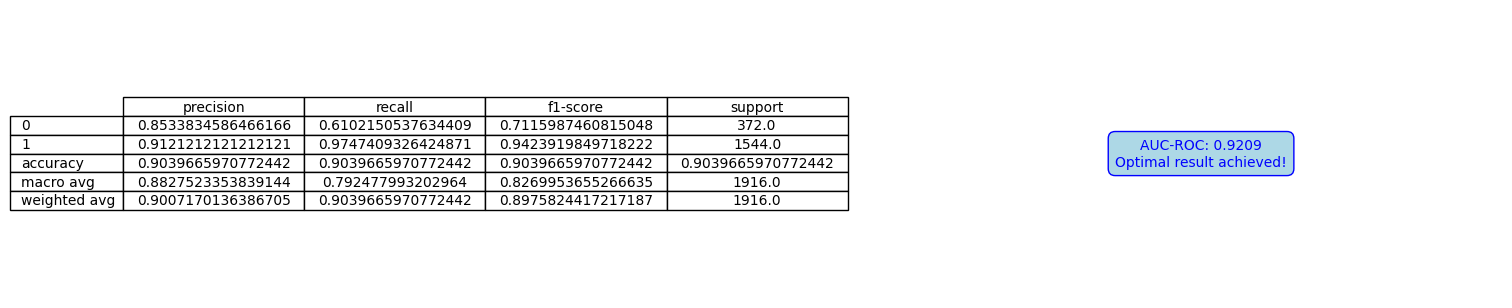

In [52]:
# Create the second block: 2 aligned plots in another row
fig2, axes2 = plt.subplots(1, 2, figsize=(16,4))  

# Classification report as a table
axes2[0].axis('off') 
table = axes2[0].table(cellText=classification_df.values, colLabels=classification_df.columns, 
                       rowLabels=classification_df.index, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Evaluation message with AUC-ROC score
axes2[1].axis('off')  # Turn off the axis
if auc_roc >= 0.8:
    evaluation_msg = "Optimal result achieved!"
elif auc_roc >= 0.7:
    evaluation_msg = "Good result, but there's room for improvement."
else:
    evaluation_msg = "The result could be improved."

# Display the evaluation message in the subplot, centered and with background styling
axes2[1].text(0.5, 0.5, f"AUC-ROC: {auc_roc:.4f}\n{evaluation_msg}", 
              fontsize=10, ha='center', va='center', color='blue', 
              bbox=dict(facecolor='lightblue', edgecolor='blue', boxstyle='round,pad=0.5'))

# Adjust layout for the second row
plt.tight_layout(pad=4.0)  
plt.show()

<div style=" border-radius: 10px; padding: 10px; background-color: #4A4A4A; max-width: 600px; margin: auto;">
<h2 style="color:white;text-align:center;">Conclusions and Recommendations</h2> 

<div style="border-radius: 10px; padding: 10px; background-color: #D3D3D3; max-width: 600px;">
  <h3 style="color:black;text-align:center;">Conclusions</h3>
</div>

During this analysis and modeling process, we have explored various aspects of loan approval prediction, including feature engineering, data balancing, and model evaluation. Key takeaways from this project include:  
- **Data** Insights: Through exploratory data analysis (EDA), we gained insights into how factors such as debt-to-income ratio, FICO score, and purpose of loan requests impact the likelihood of loan approval.  
- **Modeling Process**: We implemented a logistic regression model, enhanced with SMOTE for handling class imbalance. This approach showed promising results, as measured by the AUC-ROC score and classification metrics.  
- **Model Performance**: With an AUC-ROC score of **0.9209**, the model demonstrated effective predictive capabilities, although there is room for improvement in certain metrics (e.g., recall or precision for specific classes).  


<div style="border-radius: 10px; padding: 10px; background-color: #D3D3D3; max-width: 600px;">
  <h3 style="color:black;text-align:center;">Recommendations</h3>
</div>

- **Feature Engineering**: Additional features, such as past loan repayment history or time with the current employer, could provide more context and improve model performance.  
- **Model Comparison**: Testing other algorithms, such as Random Forest or XGBoost, may yield higher accuracy or better handling of complex relationships between features.  
- **Fine-Tuning**: Experimenting with different thresholds or using hyperparameter tuning on the classifier could further improve the balance between recall and precision.  
- **Data Collection**: Expanding the dataset to include more recent data or other socioeconomic variables may help the model generalize better.

<div style="border-radius: 10px; padding: 10px; background-color: #D3D3D3; max-width: 600px;">
  <h3 style="color:black;text-align:center;">Interactive Application</h3>
</div>

To further explore this model, you can interact with it directly on Hugging Face Spaces. The application provides a user-friendly interface where you can input applicant data and receive predictions in real-time. This feature allows you to experiment with different inputs and understand how specific factors affect loan approval predictions.

**[Click here to try the application on Hugging Face!](https://huggingface.co/spaces/AnguloM/loan_approval_app)**